# Load in the preprocessed bioactivity data 

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('cox2_data_curated_03.csv')

# Calculate Lipinski descriptors

## Rule of five developed by Christopher Lipinski to determine Druglikeness 
## Based on ADMET pharmacokinetic properites/profiles

Lipinskis rules are the following:
- MW < 500
- LogP < 5 
- HBD < 5 
- HBA < 10

In [3]:
# Import necessary libraries 
import numpy as np 
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

# Clean the smiles

In [4]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [5]:
df_no_smiles.standard_value.describe()

count    4.384000e+03
mean     5.648636e+04
std      1.038730e+06
min      0.000000e+00
25%      1.600000e+02
50%      1.900000e+03
75%      1.379275e+04
max      6.000000e+07
Name: standard_value, dtype: float64

In [6]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [7]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)

In [8]:
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL297008,60.00,active,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1
1,CHEMBL289813,3230.00,intermediate,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1
2,CHEMBL43736,80.00,active,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...
3,CHEMBL140167,0.12,active,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1
4,CHEMBL44194,100000.00,inactive,CCc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1
...,...,...,...,...
4379,CHEMBL4637729,102000.00,inactive,O=[N+]([O-])c1ccc(-n2c(-c3ccc(Br)cc3)nc3ccccc3...
4380,CHEMBL4644152,162000.00,inactive,O=[N+]([O-])c1ccc(-n2c(-c3ccccc3)nc3ccccc32)cc1
4381,CHEMBL4644109,193000.00,inactive,Nc1ccc(-n2c(-c3ccc(Cl)cc3)nc3ccccc32)cc1
4382,CHEMBL4640459,173000.00,inactive,Nc1ccc(-c2nc3ccccc3n2-c2ccc(N)cc2)cc1


In [9]:
#Compute descriptors using smiles
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [10]:
df_lipinski = lipinski(df.canonical_smiles)

In [11]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,311.406,3.85622,0.0,3.0
1,357.406,3.80782,0.0,4.0
2,469.965,6.22772,0.0,4.0
3,335.397,6.38170,1.0,0.0
4,343.423,4.24930,0.0,3.0
...,...,...,...,...
4379,394.228,5.36320,0.0,4.0
4380,315.332,4.60070,0.0,4.0
4381,319.795,4.92810,1.0,3.0
4382,300.365,3.85690,2.0,4.0


# Combine the two dataframes

In [12]:
df_combined = pd.concat([df, df_lipinski], axis=1)

In [13]:
df_combined = df_combined[df_combined.standard_value != 0]

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:xlabel='molecule_chembl_id', ylabel='standard_value'>

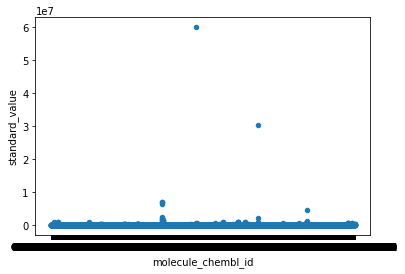

In [15]:
# Distribution of ic50 before negative logarithmic transformation
df_combined.plot.scatter(x='molecule_chembl_id', y='standard_value')

In [16]:
df_combined.standard_value.describe()

count    4.377000e+03
mean     5.657670e+04
std      1.039558e+06
min      6.000000e-03
25%      1.698200e+02
50%      1.910000e+03
75%      1.390000e+04
max      6.000000e+07
Name: standard_value, dtype: float64

# Convert IC50 to pIC50 
applying a negative logarithmic tranformation to the IC50 values to make the distribution more even

In [17]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [18]:
# Cap the standard values so the resulting pic50 is not negative as it can turn into a negative for large numbers
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop(columns = 'standard_value', axis = 1)
        
    return x

In [19]:
# apply norm function to normalise the column
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,active,311.406,3.85622,0.0,3.0,60.00
1,CHEMBL289813,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,intermediate,357.406,3.80782,0.0,4.0,3230.00
2,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,active,469.965,6.22772,0.0,4.0,80.00
3,CHEMBL140167,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,active,335.397,6.38170,1.0,0.0,0.12
4,CHEMBL44194,CCc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,inactive,343.423,4.24930,0.0,3.0,100000.00
...,...,...,...,...,...,...,...,...
4379,CHEMBL4637729,O=[N+]([O-])c1ccc(-n2c(-c3ccc(Br)cc3)nc3ccccc3...,inactive,394.228,5.36320,0.0,4.0,102000.00
4380,CHEMBL4644152,O=[N+]([O-])c1ccc(-n2c(-c3ccccc3)nc3ccccc32)cc1,inactive,315.332,4.60070,0.0,4.0,162000.00
4381,CHEMBL4644109,Nc1ccc(-n2c(-c3ccc(Cl)cc3)nc3ccccc32)cc1,inactive,319.795,4.92810,1.0,3.0,193000.00
4382,CHEMBL4640459,Nc1ccc(-c2nc3ccccc3n2-c2ccc(N)cc2)cc1,inactive,300.365,3.85690,2.0,4.0,173000.00


In [20]:
df_norm.standard_value_norm.describe()

count    4.377000e+03
mean     5.657670e+04
std      1.039558e+06
min      6.000000e-03
25%      1.698200e+02
50%      1.910000e+03
75%      1.390000e+04
max      6.000000e+07
Name: standard_value_norm, dtype: float64

### Call the pIC50 function

In [21]:
df_final = pIC50(df_norm)
df_final

C:\Users\ryzen5\AppData\Local\Temp/ipykernel_1232/3442786292.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x = input.drop('standard_value_norm', 1)


,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,active,311.406,3.85622,0.0,3.0,7.221849
1,CHEMBL289813,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,intermediate,357.406,3.80782,0.0,4.0,5.490797
2,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,active,469.965,6.22772,0.0,4.0,7.096910
3,CHEMBL140167,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,active,335.397,6.38170,1.0,0.0,9.920819
4,CHEMBL44194,CCc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,inactive,343.423,4.24930,0.0,3.0,4.000000
...,...,...,...,...,...,...,...,...
4379,CHEMBL4637729,O=[N+]([O-])c1ccc(-n2c(-c3ccc(Br)cc3)nc3ccccc3...,inactive,394.228,5.36320,0.0,4.0,3.991400
4380,CHEMBL4644152,O=[N+]([O-])c1ccc(-n2c(-c3ccccc3)nc3ccccc32)cc1,inactive,315.332,4.60070,0.0,4.0,3.790485
4381,CHEMBL4644109,Nc1ccc(-n2c(-c3ccc(Cl)cc3)nc3ccccc32)cc1,inactive,319.795,4.92810,1.0,3.0,3.714443
4382,CHEMBL4640459,Nc1ccc(-c2nc3ccccc3n2-c2ccc(N)cc2)cc1,inactive,300.365,3.85690,2.0,4.0,3.761954


<AxesSubplot:xlabel='molecule_chembl_id', ylabel='pIC50'>

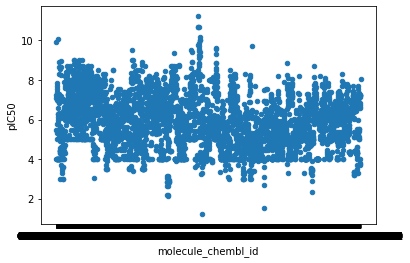

In [22]:
# Distribution of ic50 after negative logarithmic transformation also known as pIC50
df_final.plot.scatter(x='molecule_chembl_id', y='pIC50')

# Removing 'Intermediate' bioactivity class

In [50]:
df_3_class= df_final

In [51]:
df_3_class.to_csv('cox-2_3_classes.csv')

In [23]:
df_2_class = df_final[df_final['class'] != 'intermediate']

In [24]:
df_2_class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,active,311.406,3.85622,0.0,3.0,7.221849
2,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,active,469.965,6.22772,0.0,4.0,7.096910
3,CHEMBL140167,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,active,335.397,6.38170,1.0,0.0,9.920819
4,CHEMBL44194,CCc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,inactive,343.423,4.24930,0.0,3.0,4.000000
6,CHEMBL288773,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1Cc1ccc(F)cc1,inactive,343.423,4.05442,0.0,3.0,4.000000
...,...,...,...,...,...,...,...,...
4379,CHEMBL4637729,O=[N+]([O-])c1ccc(-n2c(-c3ccc(Br)cc3)nc3ccccc3...,inactive,394.228,5.36320,0.0,4.0,3.991400
4380,CHEMBL4644152,O=[N+]([O-])c1ccc(-n2c(-c3ccccc3)nc3ccccc32)cc1,inactive,315.332,4.60070,0.0,4.0,3.790485
4381,CHEMBL4644109,Nc1ccc(-n2c(-c3ccc(Cl)cc3)nc3ccccc32)cc1,inactive,319.795,4.92810,1.0,3.0,3.714443
4382,CHEMBL4640459,Nc1ccc(-c2nc3ccccc3n2-c2ccc(N)cc2)cc1,inactive,300.365,3.85690,2.0,4.0,3.761954


In [26]:
df_2_class.pIC50.describe()

count    3346.000000
mean        5.919458
std         1.503933
min         1.221849
25%         4.522879
50%         6.200659
75%         7.096910
max        11.221849
Name: pIC50, dtype: float64

In [27]:
df_2_class.to_csv('cox-2_2_classes.csv')

# Exploratory data analysis

In [32]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

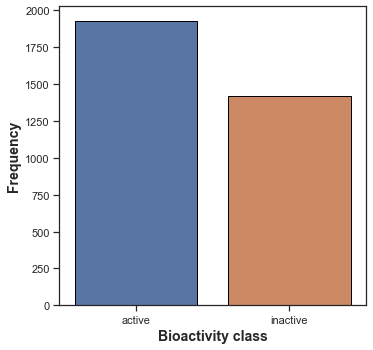

In [34]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2_class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

# Scatter plot of MW against LogP

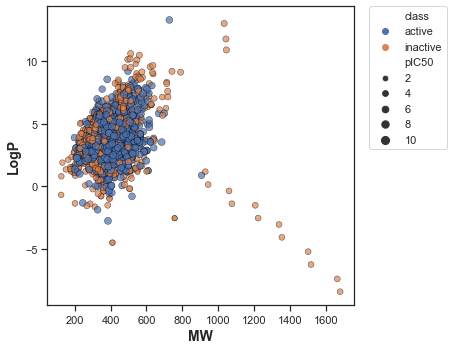

In [35]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2_class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

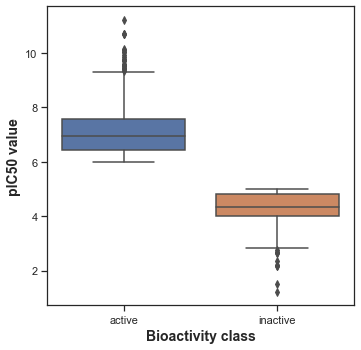

In [36]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2_class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [37]:
# mann whitney u

def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2_class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2_class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [38]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,2732880.0,0.0,0.05,Different distribution (reject H0)


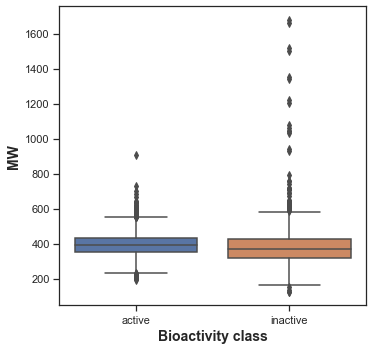

In [40]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2_class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [41]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1561556.0,1.581475e-12,0.05,Different distribution (reject H0)


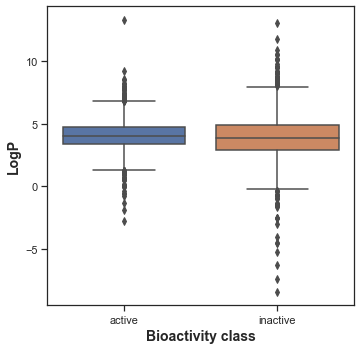

In [43]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2_class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [44]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1452080.0,0.001923,0.05,Different distribution (reject H0)


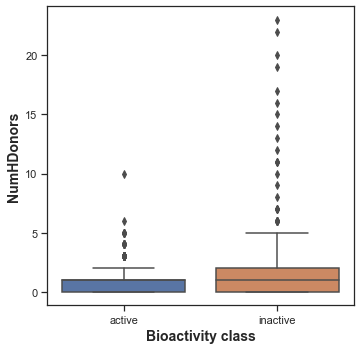

In [46]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2_class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [47]:
mannwhitney('NumHDonors')


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1197049.0,5.975426e-11,0.05,Different distribution (reject H0)


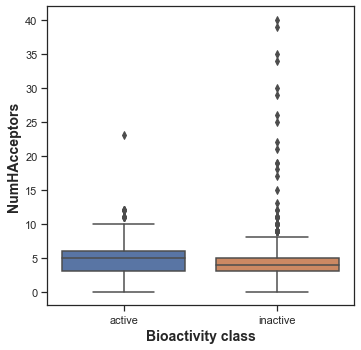

In [48]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2_class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [49]:
mannwhitney('NumHAcceptors')


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1455068.5,0.001096,0.05,Different distribution (reject H0)
